# Importing Libraries

In [22]:
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.cluster import KMeans

from IPython.display import clear_output
import time

from sklearn.linear_model import LinearRegression as lr
from sklearn.preprocessing import PolynomialFeatures as pf, StandardScaler as ss, MinMaxScaler as mms
from sklearn.metrics import r2_score

import sys

sns.set_style('whitegrid')
sns.set_context('notebook')

import warnings
warnings.simplefilter('ignore')

colors = ['orange', 'darkblue', 'yellow', 'darkred', 'darkgreen', 'purple', 'lightgreen', 'pink', 'black', 'lightblue']*7     # Colors to differentiate clusters

# Loading Data

In [23]:
data_path = '\\Users\luisr\Desktop\Repository\Data-Science-Projects\Data_Science_Projects\Clusters Demográficos e Econômicos de Bairros do Rio de Janeiro\Data\Final Data\\gym_neighborhood_data.csv'
data = pd.read_csv(data_path)

# Feature Engineering

In [24]:
data['adult pop'] = data[data.columns.tolist()[23:29]].sum(axis=1)
data['adult_pop/Km2'] = data['adult pop'] / data['Km2']

cols = data.columns.tolist()
data.columns.tolist()[23:29]

['30 a 34 anos',
 '35 a 39 anos',
 '40 a 49 anos',
 '50 a 59 anos',
 '60 a 64 anos',
 '65 a 69 anos']

# Feature Selection

### Income

In [25]:
income = data[['neighborhood']+[cols[40]]].set_index('neighborhood').copy()    # Include Total Salary
income[cols[38]+'/Km2'] = (data.set_index('neighborhood')[cols[38]] / data.set_index('neighborhood')['Km2']).to_frame()
income[cols[39]+'/Km2'] = (data.set_index('neighborhood')[cols[39]] / data.set_index('neighborhood')['Km2']).to_frame()

income_cols = cols[33:42]+[cols[38]+'/Km2', cols[39]+'/Km2']

[cols[38], cols[39], cols[40]]

['Pessoas com rendimento responsáveis pelos domicílios particulares permanentes',
 'Valor do rendimento total mensal das pessoas com rendimento, responsáveis pelos domicílios particulares permanentes (R$)',
 'Valor do rendimento nominal médio mensal das pessoas com rendimento, responsáveis pelos domicílios particulares permanentes (R$)']

In [26]:
income_cols[5:7]

['Pessoas com rendimento responsáveis pelos domicílios particulares permanentes',
 'Valor do rendimento total mensal das pessoas com rendimento, responsáveis pelos domicílios particulares permanentes (R$)']

In [27]:
income.columns

Index(['Valor do rendimento nominal médio mensal das pessoas com rendimento, responsáveis pelos domicílios particulares permanentes (R$)',
       'Pessoas com rendimento responsáveis pelos domicílios particulares permanentes/Km2',
       'Valor do rendimento total mensal das pessoas com rendimento, responsáveis pelos domicílios particulares permanentes (R$)/Km2'],
      dtype='object')

### Population

In [28]:
pop = data[['neighborhood', 'adult pop', 'adult_pop/Km2', 'target pop', 'target_pop/Km2', 'Km2']].set_index('neighborhood').copy()

### Comerce

In [29]:
comerce_features = [ 'Comércio varejista_x',
                     'Instituições de crédito, seguros e capitalização_x',
                     'Comércio e administração de imóveis, valores mobiliários, serviços técnicos_x',
                     'Serviços de alojamento, alimentação, reparação, manutenção, redação..._x',
                     'Serviços médicos, odontológicos e veterinários_x',
                     'Ensino_x']

comerce = data[['neighborhood']+comerce_features].set_index('neighborhood').copy()

# Modeling

## 1. Income

In [30]:
save_figs = False

colors = ['orange', 'darkblue', 'yellow', 'darkred', 'darkgreen', 'purple', 'lightgreen', 'pink', 'black', 'lightblue']*7     # Colors to differentiate clusters

income_log = income[income.columns[:3]].apply(np.log1p).fillna(0)
income_ss = ss().fit_transform(income_log)
income_mms = mms().fit_transform(income_log)

# Clustering

In [31]:
variable = income.columns[0]

kmeans = KMeans(n_clusters=10, n_init=30).fit(income_ss)
income['cluster'] = kmeans.labels_

clusters = income['cluster'].copy()
sorted_clusters = income.groupby('cluster').mean().sort_values(by=variable).index.tolist()
    
kmeans.n_iter_

5

# Regression

In [32]:
        iis = data.set_index('neighborhood')[[income_cols[6]]]
        js = data.set_index('neighborhood')[[income_cols[5]]]
        ks = data.set_index('neighborhood')[['Km2']]

        xs = income[[income.columns[0]]]
        ys = income[[income.columns[1]]]
        zs = income[[income.columns[2]]]
    
        xs_i = [income[clusters==cluster][[income.columns[0]]] for cluster in sorted_clusters]
        ys_i = [income[clusters==cluster][[income.columns[1]]] for cluster in sorted_clusters]
        zs_i = [income[clusters==cluster][[income.columns[2]]] for cluster in sorted_clusters]

        iis_i = [data.set_index('neighborhood')[clusters==cluster][[income_cols[6]]] for cluster in sorted_clusters]
        js_i = [data.set_index('neighborhood')[clusters==cluster][[income_cols[5]]] for cluster in sorted_clusters]
        ks_i = [data.set_index('neighborhood')[clusters==cluster][['Km2']] for cluster in sorted_clusters]

        x1_i = [np.linspace(x.min(), x.max(), 200) for x in xs_i]
        y1_i = [np.linspace(y.min(), y.max(), 200) for y in ys_i]
        z1_i = [np.linspace(z.min(), z.max(), 200) for z in zs_i]

        ii1_i = [np.linspace(i.min(), i.max(), 200) for i in iis_i]
        j1_i = [np.linspace(j.min(), j.max(), 200) for j in js_i]
        k1_i = [np.linspace(k.min(), k.max(), 200) for k in ks_i]
   
    
        a1_i, b1_i = [], []
        a2_i, b2_i = [], []
        a3_i, b3_i = [], []
        a4_i, b4_i = [], []
        a5_i, b5_i = [], []
        a6_i, b6_i = [], []
    
        for i in range(len(sorted_clusters)):
            
            lr1 = lr().fit(js_i[i], iis_i[i])
        
            a1_i.append(lr1.coef_[0][0])
            b1_i.append(lr1.intercept_[0])
        
            lr2 = lr().fit(ks_i[i], js_i[i])
            
            a2_i.append(lr2.coef_[0][0])
            b2_i.append(lr2.intercept_[0])

            lr3 = lr().fit(iis_i[i], ks_i[i])
        
            a3_i.append(lr3.coef_[0][0])
            b3_i.append(lr3.intercept_[0])
    
            lr4 = lr().fit(iis_i[i], js_i[i])
        
            a4_i.append(lr4.coef_[0][0])
            b4_i.append(lr4.intercept_[0])
        
            lr5 = lr().fit(js_i[i], ks_i[i])
        
            a5_i.append(lr5.coef_[0][0])
            b5_i.append(lr5.intercept_[0])
        
            lr6 = lr().fit(ks_i[i], iis_i[i])
        
            a6_i.append(lr6.coef_[0][0])
            b6_i.append(lr6.intercept_[0])
        

# Predictions

In [33]:
        ij_pred = [a*j + b for a, b, j in zip(a1_i, b1_i, js_i)]
        jk_pred = [a*k + b for a, b, k in zip(a2_i, b2_i, ks_i)]
        ki_pred = [a*i+ b for a, b, i in zip(a3_i, b3_i, iis_i)]

        ji_pred = [a*i + b for a, b, i in zip(a4_i, b4_i, iis_i)]
        kj_pred = [a*j + b for a, b, j in zip(a5_i, b5_i, js_i)]
        ik_pred = [a*k + b for a, b, k in zip(a6_i, b6_i, ks_i)]

        ij_pred_grid = [a*j + b for a, b, j in zip(a1_i, b1_i, j1_i)]
        jk_pred_grid = [a*k + b for a, b, k in zip(a2_i, b2_i, k1_i)]
        ki_pred_grid = [a*i + b for a, b, i in zip(a3_i, b3_i, ii1_i)]

        ji_pred_grid = [a*i + b for a, b, i in zip(a4_i, b4_i, ii1_i)]
        kj_pred_grid = [a*j + b for a, b, j in zip(a5_i, b5_i, j1_i)]
        ik_pred_grid = [a*k + b for a, b, k in zip(a6_i, b6_i, k1_i)]

### Plot Method 1

In [34]:
x1 = np.linspace(xs.min(), xs.max(), 200)
y1 = np.linspace(ys.min(), ys.max(), 200)
#z1 = np.linspace(zs.min(), zs.max(), 200)
 
x2, y2 = np.meshgrid(x1,y1)      

z_pred_1 = np.array([x*y for x,y in zip(x2, y2)])

### Plot Method 2

In [35]:
x1 = np.linspace(-10, 10, 200)
y1 = np.linspace(-10, 10, 200)
#z1 = np.linspace(zs.min(), zs.max(), 200)
 
x3, y3 = np.meshgrid(x1,y1)      

z_pred_2 = np.array([x*y for x,y in zip(x3, y3)])

# Visualizing Result

In [36]:
fig_path = 'Plots\{}'

### Bar plot

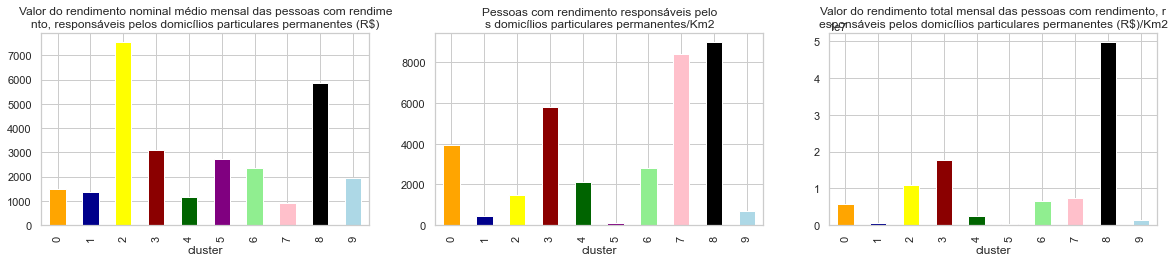

In [37]:
income_mean = income.groupby('cluster').mean()

fig = plt.figure(figsize=(20,12))
axes = [fig.add_subplot(3,3,i) for i in range(1, len(income.columns))]

for i, col in enumerate(income_mean):
    income_mean[col].plot(kind='bar', ax=axes[i], title=income.columns[i][:int(len(income.columns[i])/2)]+'\n'+income.columns[i][int(len(income.columns[i])/2):], color=[colors[j] for j in range(len(income['cluster'].unique()))])

fig.savefig(fig_path.format('Income_clusters_average_barplot.png'))

### Boxplot

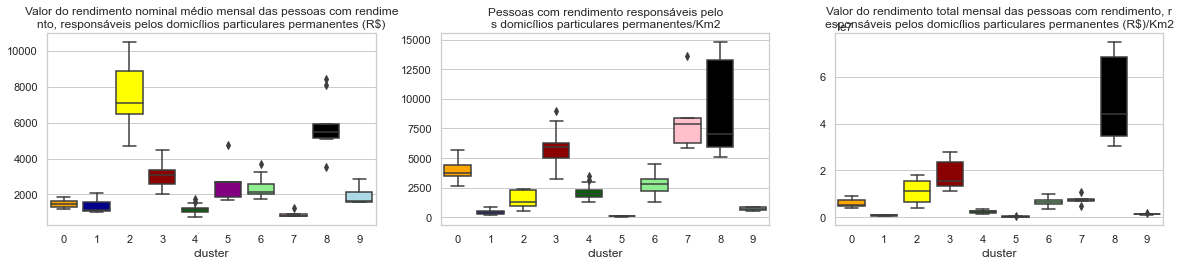

In [38]:
fig = plt.figure(figsize=(20,12))
axes=[fig.add_subplot(3,3,i+1) for i in range(len(income.columns)-1)]

for i in range(len(income.columns)-1):
    
    sns.boxplot(data=income, x='cluster', y=income.columns[i], ax=axes[i])
    axes[i].set_ylabel('')
    axes[i].set_title(income.columns[i][:int(len(income.columns[i])/2)]+'\n'+income.columns[i][int(len(income.columns[i])/2):])
    
    #if i==len(income.columns)-3:
     #   axes[i].set_ylim(-10000000,1e9*0.2)
    
    for j in range(len(income['cluster'].unique())):
        axes[i].artists[j].set_facecolor(colors[j])    # Setting colors to match clusters colors.

fig.savefig(fig_path.format('Income_clusters_boxplot.png'))

# XYZ

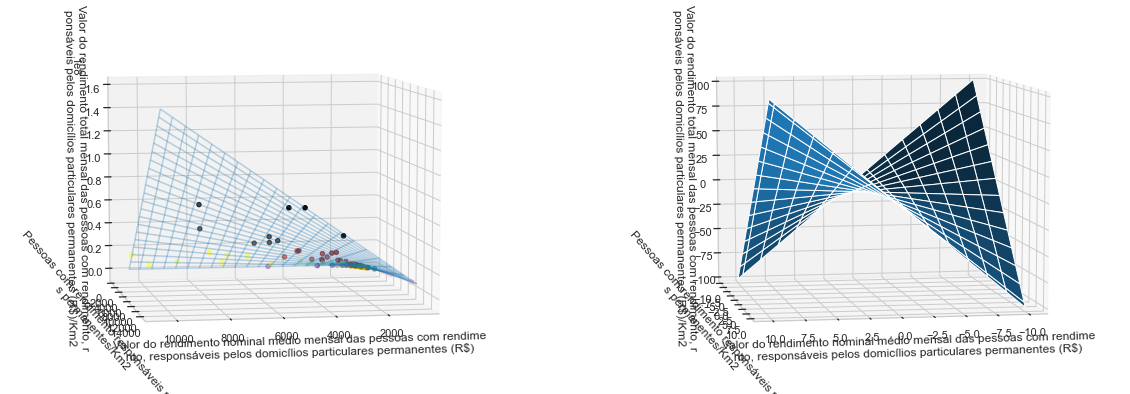

In [39]:
for angle in range(0,360,14):
    
    clear_output(wait=True)
    
    fig = plt.figure(figsize=(20,7))
    axes = [fig.add_subplot(1,2,i, projection='3d') for i in [1,2]]

    axes[0].plot_wireframe(x2, y2, z_pred_1, alpha=0.3, rstride=10, cstride=10)
    
    axes[0].set_xlabel(xs.columns[0][:int(len(xs.columns[0])/2)]+'\n'+xs.columns[0][int(len(xs.columns[0])/2):])
    axes[0].set_ylabel(ys.columns[0][:int(len(ys.columns[0])/2)]+'\n'+ys.columns[0][int(len(xs.columns[0])/2):])
    axes[0].set_zlabel(zs.columns[0][:int(len(zs.columns[0])/2)]+'\n'+zs.columns[0][int(len(xs.columns[0])/2):])

    axes[1].plot_surface(x3, y3, z_pred_2, alpha=1, rstride=15, cstride=15)
    
    axes[1].set_xlabel(xs.columns[0][:int(len(xs.columns[0])/2)]+'\n'+xs.columns[0][int(len(xs.columns[0])/2):])
    axes[1].set_ylabel(ys.columns[0][:int(len(ys.columns[0])/2)]+'\n'+ys.columns[0][int(len(xs.columns[0])/2):])
    axes[1].set_zlabel(zs.columns[0][:int(len(zs.columns[0])/2)]+'\n'+zs.columns[0][int(len(xs.columns[0])/2):])

    axes[0].scatter(xs, ys, zs, color=[colors[cluster] for cluster in income['cluster']])
    
    
#ax0.set_zlim(-1000, 30000)
#ax0.set_xlim(-100, 4000)
#ax0.set_zlim(-1000, 30000)
    
    axes[0].view_init(8, angle+90)
    axes[1].view_init(8, angle+90)
    
    plt.show()
    plt.pause(0.0001)
    
fig.savefig(fig_path.format('Income_clusters_3dplot.png'))

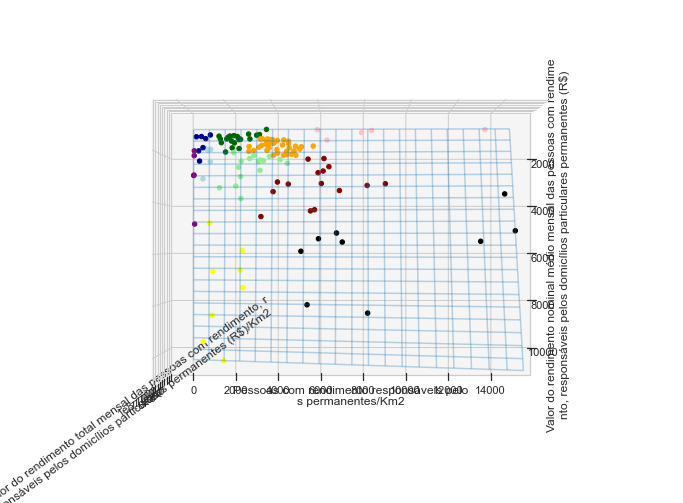

In [40]:
for angle in range(0,361,9):
    
    clear_output(wait=True)
    
    fig = plt.figure(figsize=(12,9))
    ax0 = fig.add_subplot(111, projection='3d')

    ax0.scatter(xs, ys, zs=zs, c=[colors[cluster] for cluster in income['cluster']], alpha=1)
    ax0.plot_wireframe(x2, y2, z_pred_1, alpha=0.3, rstride=10, cstride=10)
    
    ax0.set_xlabel(xs.columns[0][:int(len(xs.columns[0])/2)]+'\n'+xs.columns[0][int(len(xs.columns[0])/2):])
    ax0.set_ylabel(ys.columns[0][:int(len(ys.columns[0])/2)]+'\n'+ys.columns[0][int(len(xs.columns[0])/2):])
    ax0.set_zlabel(zs.columns[0][:int(len(zs.columns[0])/2)]+'\n'+zs.columns[0][int(len(xs.columns[0])/2):])

#ax0.set_zlim(-1000, 30000)
#ax0.set_xlim(-100, 4000)
#ax0.set_zlim(-1000, 30000)
    
    ax0.view_init(angle/4, angle)
    plt.show()
    plt.pause(0.001)

fig.savefig(fig_path.format('Income_clusters_topview.png'))

## Bar Plot

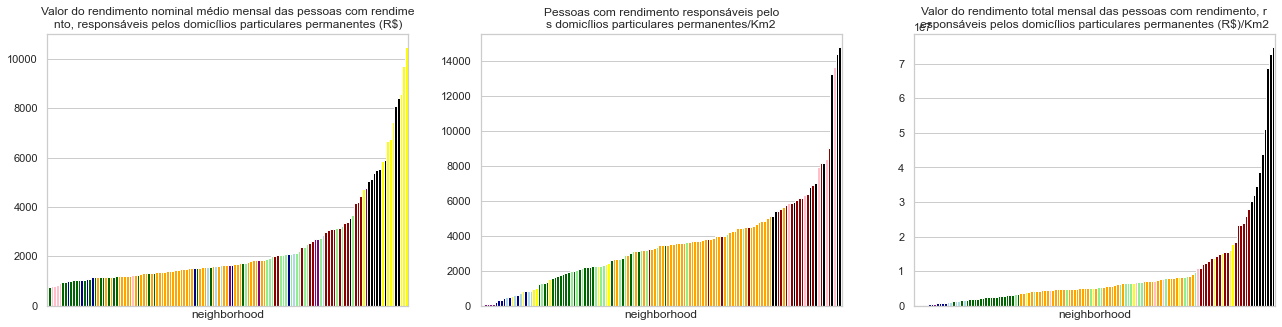

In [41]:
fig, axes = plt.subplots(1,3,figsize=(22,5))

for i, col in zip(range(3), income.columns[:-1]):
    
    income.sort_values(by=col)[col].plot.bar(color=[colors[cluster] for cluster in income.sort_values(by=col)['cluster']], xticks=[], ax=axes[i], title=col[:int(len(col)/2)] + '\n' + col[int(len(col)/2):], width=1)

fig.savefig(fig_path.format('Income_clusters_barplot.png'))

# Filtering by Income:

In [42]:
{index:colors[index] for index in income['cluster'].unique()}

{3: 'darkred',
 5: 'purple',
 0: 'orange',
 6: 'lightgreen',
 4: 'darkgreen',
 2: 'yellow',
 8: 'black',
 9: 'lightblue',
 7: 'pink',
 1: 'darkblue'}

#### Top cluster: 0

In [43]:
income_filt = income[income['cluster'].isin([8,3])].copy()

filtered1 = income_filt.copy()

filtered1.shape

(24, 4)

In [44]:
filtered1.iloc[:, :-1]

,"Valor do rendimento nominal médio mensal das pessoas com rendimento, responsáveis pelos domicílios particulares permanentes (R$)",Pessoas com rendimento responsáveis pelos domicílios particulares permanentes/Km2,"Valor do rendimento total mensal das pessoas com rendimento, responsáveis pelos domicílios particulares permanentes (R$)/Km2"
neighborhood,,,
abolição,2015.730597,6167.124165,1.243126e+07
andarai,3072.576839,6048.731734,1.858519e+07
botafogo,5146.563820,6757.094905,3.477582e+07
cachambi,2546.786807,6130.675845,1.561352e+07
catete,3545.980726,14398.847396,5.105804e+07
copacabana,5065.249035,14778.886684,7.485874e+07
flamengo,5492.289701,13234.899026,7.268990e+07
gloria,3405.067082,3805.044595,1.295643e+07
humaita,5901.564179,5120.081906,3.021649e+07


In [45]:
recom_path = 'Recommendation Datasets\{}'

In [46]:
import dataframe_image as dfi
 

In [77]:
dfi.export(filtered1.iloc[:, :-1], recom_path.format('ByIncome.png'))

filtered1.describe()

income.describe()

# Population

In [48]:
pop = data[['neighborhood', 'adult_pop/Km2', 'target_pop/Km2']].set_index('neighborhood').copy()

In [49]:
#pop2 = data[['neighborhood', 'adult_pop/Km2', 'target pop', 'target_pop/Km2', 'Km2']].set_index('neighborhood').copy()

pop = pop.loc[filtered1.index].copy()

pop = pop_filt.copy()

([], <a list of 0 Text major ticklabel objects>)

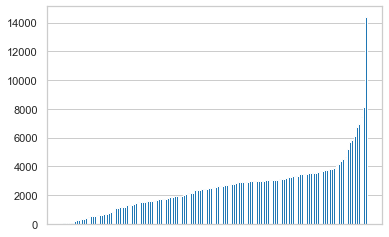

In [50]:
plt.bar(x=pop.sort_values(by='target_pop/Km2').index, height = pop['target_pop/Km2'].sort_values())

plt.xticks([])

([], <a list of 0 Text major ticklabel objects>)

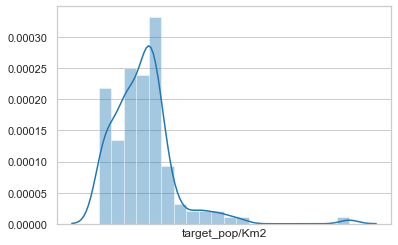

In [51]:
sns.distplot(pop['target_pop/Km2'].sort_values(), bins=20)

plt.xticks([])

# Data Transformation

In [52]:
from sklearn.preprocessing import StandardScaler as ss, MinMaxScaler as mms

In [53]:
pop = data[['neighborhood', 'adult_pop/Km2', 'target_pop/Km2']].set_index('neighborhood').copy()

In [54]:
pop_log = pop.apply(np.log1p)#[['pop/Km2', 'target_pop/Km2']]

pop_ss = ss().fit_transform(pop_log)
pop_mms = mms().fit_transform(pop_log)

# KMeans

In [55]:
from sklearn.cluster import KMeans

In [56]:
colors = ['orange', 'darkblue', 'yellow', 'darkred', 'darkgreen', 'purple', 'lightgreen', 'pink', 'black', 'lightblue']*6     # Colors to differentiate clusters

In [60]:
kmeans = KMeans(n_clusters=7, n_init=30).fit(pop_ss)
pop['cluster'] = kmeans.labels_

### Bar plot

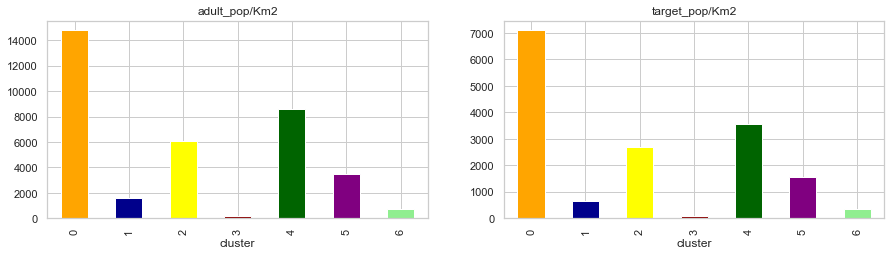

In [61]:
pop_mean = pop.groupby('cluster').mean()

fig = plt.figure(figsize=(15,8))
axes = [fig.add_subplot(2,2,i) for i in range(1, len(pop.columns))]

for i, col in enumerate(pop_mean):
    pop_mean[col].plot(kind='bar', ax=axes[i], title=pop.columns[i], color=[colors[j] for j in range(len(pop['cluster'].unique()))])
    
fig.savefig(fig_path.format('population_clusters_average_barplot.png'))

### Boxplot

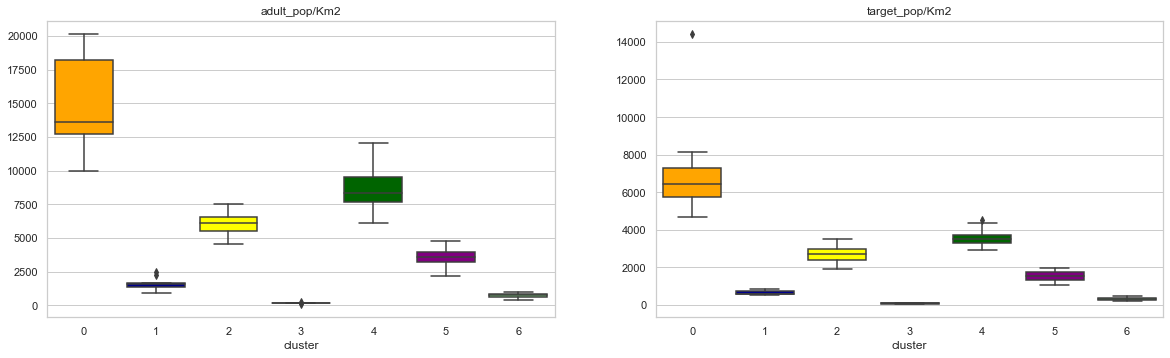

In [62]:
fig = plt.figure(figsize=(20,12))
axes=[fig.add_subplot(2,2,i+1) for i in range(len(pop.columns)-1)]

for i in range(len(pop.columns)-1):
    
    sns.boxplot(data=pop, x='cluster', y=pop.columns[i], ax=axes[i])
    axes[i].set_ylabel('')
    axes[i].set_title(pop.columns[i])
    
    #if i==len(income.columns)-3:
     #   axes[i].set_ylim(-10000000,1e9*0.2)
    
    for j in range(len(pop['cluster'].unique())):
        axes[i].artists[j].set_facecolor(colors[j])    # Setting colors to match clusters colors.
        
fig.savefig(fig_path.format('population_clusters_boxplot.png'))

### 3D Scatter Plot

In [63]:
from IPython.display import clear_output

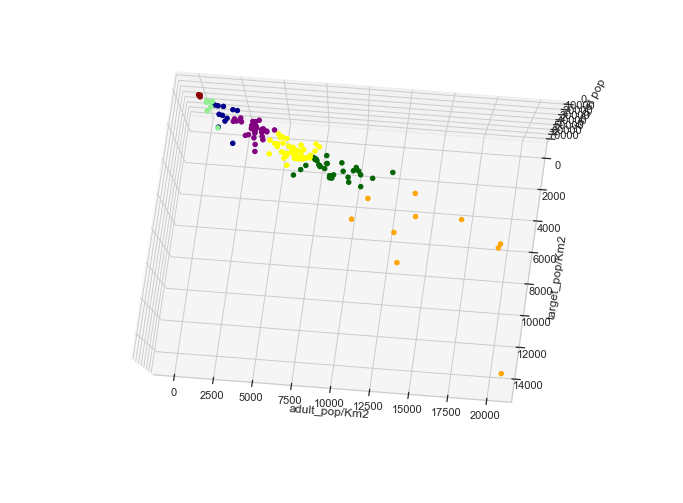

In [111]:
ys = pop['target_pop/Km2']
xs = pop['adult_pop/Km2']
zs = data['target pop']
zss = pop.iloc[:, 0]

c=0
for angle in range(0,270,12):
    c+=1
    fig.savefig(fig_path.format('population clusters 3d rotation\population_clusters{}°.png'.format(angle)))
    fig = plt.figure(figsize=(12,9))
    ax0 = fig.add_subplot(111, projection='3d')


    ax0.scatter(xs, ys, zs=zs, c=[colors[cluster] for cluster in pop['cluster']], alpha=1)


    ax0.set_ylabel('target_pop/Km2', fontsize=12)
    ax0.set_xlabel('adult_pop/Km2', fontsize=12)
    ax0.set_zlabel('target pop', fontsize=12)

#ax0.set_zlim(-1000, 30000)
#ax0.set_xlim(-100, 4000)
#ax0.set_zlim(-1000, 30000)

    ax0.view_init(angle,angle)
    plt.show()
    plt.pause(0.001)
    
    clear_output(wait=True)

#fig.savefig(fig_path.format('population_clusters_topview.png'))

### Bar Plots

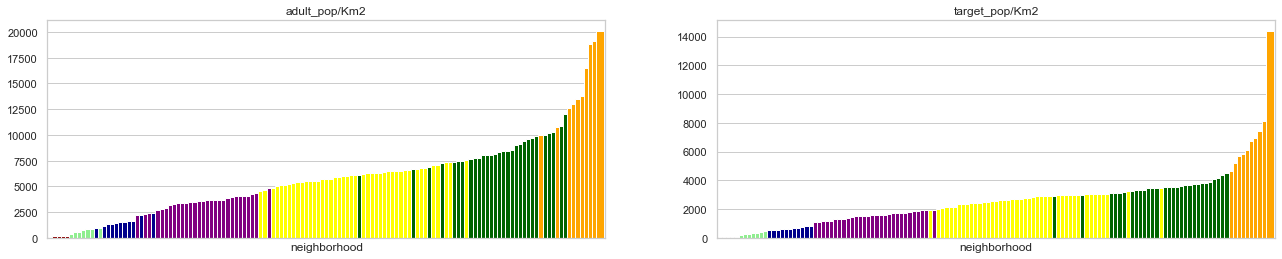

In [70]:
fig, axes = plt.subplots(1,2,figsize=(22,4))

for i, col in zip(range(4), pop.columns[:-1]):
    
    pop.sort_values(by=col)[col].plot.bar(color=[colors[cluster] for cluster in pop.sort_values(by=col)['cluster']], xticks=[], ax=axes[i], title=col, width=2)
    
fig.savefig(fig_path.format('population_clusters_barplot.png'))

# Selecting Neighborhoods for further clustering

#### Top: cluster 6

#### Maybe cluster only by demographic density and comparing, Use dbscan. Try a separate Notebook

In [71]:
pop['cluster_i'] = income['cluster']

In [72]:
pop_filt = pop[pop['cluster'].isin([0,4])]

In [73]:
filtered2 = pop_filt.loc[[i for i in pop_filt.index if i in filtered1.index]]

#### Checking

In [74]:
pop_filt.shape, income_filt.shape, filtered2.shape

((39, 4), (24, 4), (18, 4))

In [75]:
filtered2

,adult_pop/Km2,target_pop/Km2,cluster,cluster_i
neighborhood,,,,
abolição,9738.247629,3704.168500,4,3
andarai,9123.068846,3623.136357,4,3
botafogo,9424.133413,3704.347492,4,8
cachambi,10176.610814,3746.400680,4,3
catete,18799.555702,7432.894709,0,8
copacabana,19084.823078,6713.485947,0,8
flamengo,16458.582206,5859.364604,0,8
laranjeiras,10028.043344,3524.753967,4,8
leblon,12039.872193,3491.716204,4,8


In [76]:
dfi.export(filtered2.iloc[:, :-2], recom_path.format('ByDemography.png'))

---
# Comerce

In [78]:
comerce = data[['neighborhood']+comerce_features].set_index('neighborhood').copy()

# Data Transformation

In [79]:
from sklearn.preprocessing import StandardScaler as ss, MinMaxScaler as mms

In [80]:
com_log = comerce.apply(np.log1p).fillna(0)

com_ss = ss().fit_transform(com_log)
com_mms = mms().fit_transform(com_log)

# KMeans

In [81]:
from sklearn.cluster import KMeans

In [82]:
colors = ['orange', 'darkblue', 'yellow', 'darkred', 'darkgreen', 'purple', 'lightgreen', 'pink', 'black', 'lightblue']     # Colors to differentiate clusters

### Clustering

In [83]:
kmeans = KMeans(n_clusters=7, n_init=30).fit(com_ss)
comerce['cluster'] = kmeans.labels_

### Bar plot

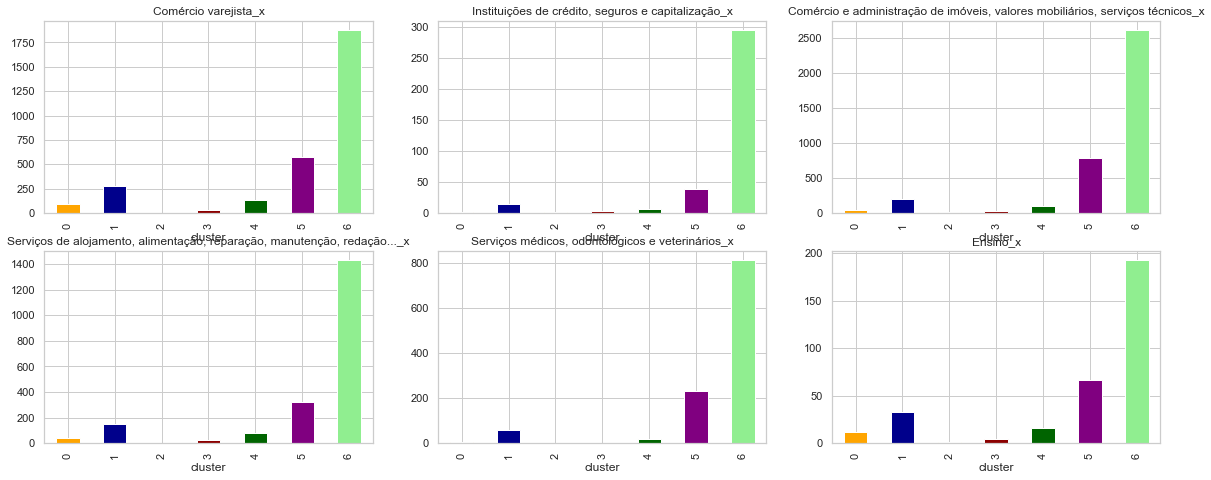

In [84]:
com_mean = comerce.groupby('cluster').mean()

fig = plt.figure(figsize=(20,12))
axes = [fig.add_subplot(3,3,i) for i in range(1, len(comerce.columns))]

for i, col in enumerate(com_mean):
    com_mean[col].plot(kind='bar', ax=axes[i], title=comerce.columns[i], color=[colors[j] for j in range(len(comerce['cluster'].unique()))])
    
fig.savefig(fig_path.format('comerce_clusters_average_barplot.png'))

### Boxplot

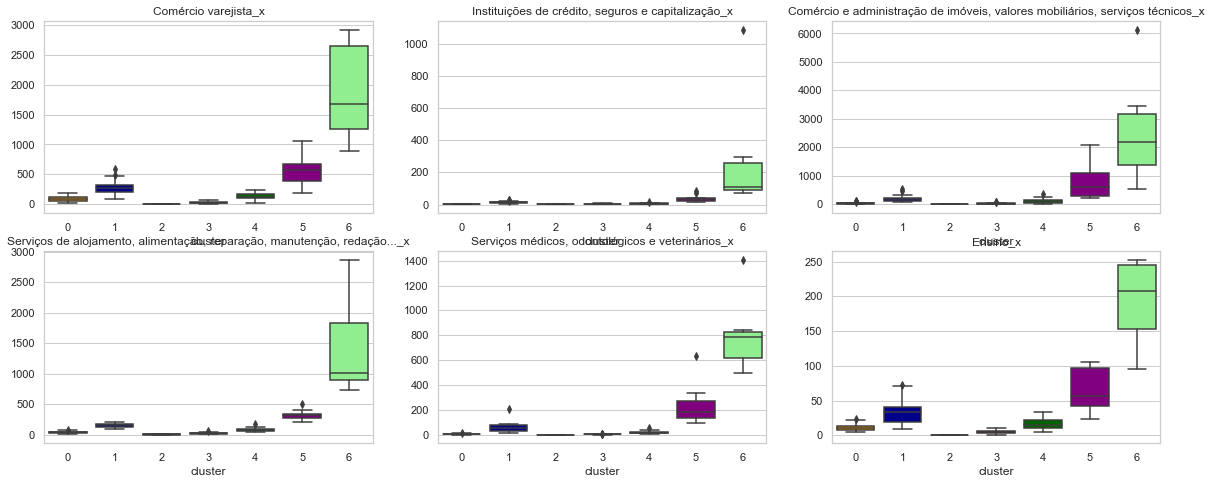

In [85]:
fig = plt.figure(figsize=(20,12))
axes=[fig.add_subplot(3,3,i+1) for i in range(len(comerce.columns)-1)]

for i in range(len(comerce.columns)-1):
    
    sns.boxplot(data=comerce, x='cluster', y=comerce.columns[i], ax=axes[i])
    axes[i].set_ylabel('')
    axes[i].set_title(comerce.columns[i])

    for j in range(len(comerce['cluster'].unique())):
        axes[i].artists[j].set_facecolor(colors[j])    # Setting colors to match clusters colors.
        
fig.savefig(fig_path.format('comerce_clusters_boxplot.png'))

### 2D Scatter Plots

In [86]:
from IPython.display import clear_output
import time

### Bar Plots

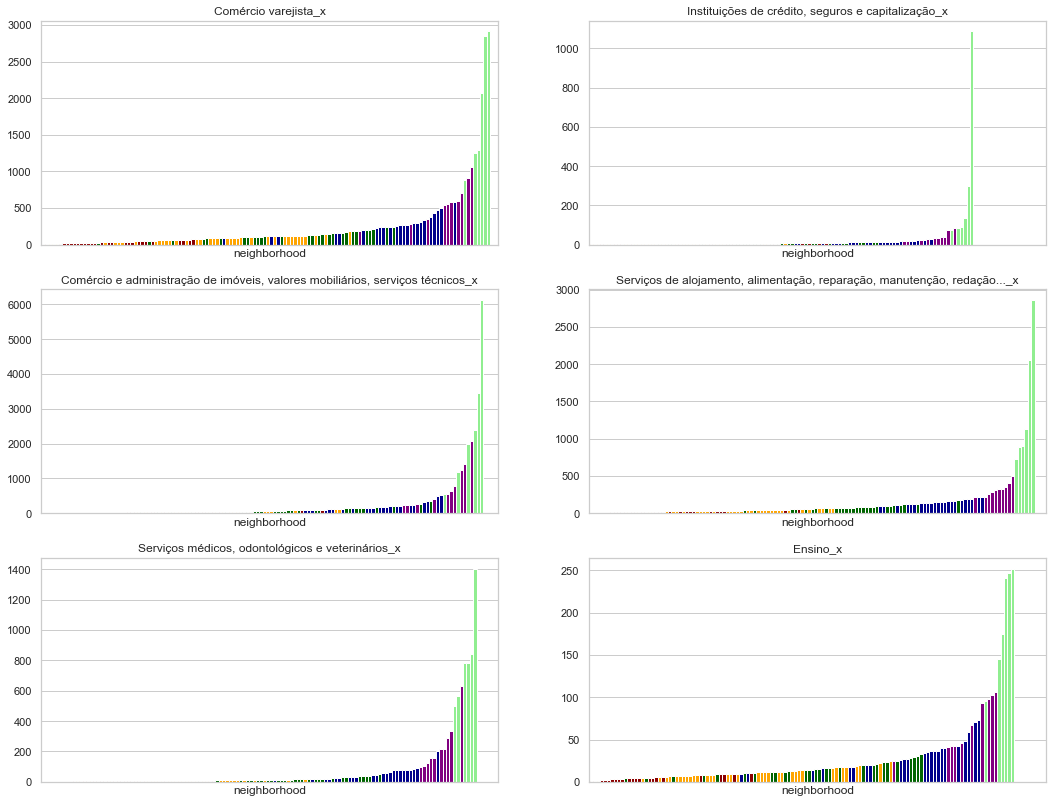

In [87]:
fig = plt.figure(figsize=(18,14))

axes = [fig.add_subplot(3,2,i) for i in range(1, len(comerce.columns))]

for i, col in enumerate(comerce.columns[:-1]):
    
    comerce.sort_values(by=col)[col].plot.bar(color=[colors[cluster] for cluster in comerce.sort_values(by=col)['cluster']], xticks=[], ax=axes[i], title=col, width=1)
    
fig.savefig(fig_path.format('comerce_clusters_barplot.png'))

# Filtering

#### Top cluster: 4

In [91]:
comerce['cluster_i'] = income['cluster'].copy()

In [92]:
comerce['cluster_j'] = pop['cluster'].copy()

In [93]:
com_filt = comerce[comerce['cluster'].isin([6,5,1])].copy()

### Third Filtering

In [94]:
filtered3 = com_filt.loc[[neighborhood for neighborhood in filtered2.index if neighborhood in com_filt.index]].copy()

In [95]:
filtered3.shape

(12, 9)

In [96]:
filtered3

,Comércio varejista_x,"Instituições de crédito, seguros e capitalização_x","Comércio e administração de imóveis, valores mobiliários, serviços técnicos_x","Serviços de alojamento, alimentação, reparação, manutenção, redação..._x","Serviços médicos, odontológicos e veterinários_x",Ensino_x,cluster,cluster_i,cluster_j
neighborhood,,,,,,,,,
andarai,195.0,25.0,249.0,133.0,13.0,14.0,1,3,4
botafogo,887.0,133.0,1181.0,896.0,564.0,145.0,6,8,4
catete,249.0,14.0,155.0,170.0,203.0,9.0,1,8,0
copacabana,1255.0,87.0,2400.0,1133.0,783.0,95.0,6,8,0
flamengo,190.0,17.0,777.0,283.0,156.0,42.0,5,8,0
laranjeiras,158.0,14.0,481.0,193.0,55.0,40.0,1,8,4
leblon,551.0,85.0,1231.0,400.0,337.0,24.0,5,8,4
maracanã,115.0,12.0,338.0,168.0,32.0,48.0,1,3,4
meier,581.0,39.0,650.0,327.0,288.0,98.0,5,3,4


In [97]:
dfi.export(filtered3.T, recom_path.format('ByComerce.png'))

## Intersection Extraction

In [98]:
filtered = pd.merge(income_filt.reset_index(), pop_filt.drop('cluster_i', axis=1).reset_index(), on='neighborhood')

filtered = pd.merge(filtered, com_filt.drop(['cluster_i', 'cluster_j'], axis=1).reset_index(), on='neighborhood')

filtered = filtered.set_index('neighborhood').rename(columns={'cluster_x':'cluster_inc', 'cluster_y':'cluster_pop', 'cluster':'cluster_com'})

In [99]:
filtered.shape, filtered3.shape

((12, 14), (12, 9))

In [105]:
clus_cols = ['cluster_inc', 'cluster_pop', 'cluster_com']

dfi.export(filtered[clus_cols], recom_path.format('general_clusters.png'))

dfi.export(filtered.drop(clus_cols, axis=1).T, recom_path.format('General.png'))

filtered.to_csv(recom_path.format('General.csv'), index=True)

In [101]:
filtered

,"Valor do rendimento nominal médio mensal das pessoas com rendimento, responsáveis pelos domicílios particulares permanentes (R$)",Pessoas com rendimento responsáveis pelos domicílios particulares permanentes/Km2,"Valor do rendimento total mensal das pessoas com rendimento, responsáveis pelos domicílios particulares permanentes (R$)/Km2",cluster_inc,adult_pop/Km2,target_pop/Km2,cluster_pop,Comércio varejista_x,"Instituições de crédito, seguros e capitalização_x","Comércio e administração de imóveis, valores mobiliários, serviços técnicos_x","Serviços de alojamento, alimentação, reparação, manutenção, redação..._x","Serviços médicos, odontológicos e veterinários_x",Ensino_x,cluster_com
neighborhood,,,,,,,,,,,,,,
andarai,3072.576839,6048.731734,1.858519e+07,3,9123.068846,3623.136357,4,195.0,25.0,249.0,133.0,13.0,14.0,1
botafogo,5146.563820,6757.094905,3.477582e+07,8,9424.133413,3704.347492,4,887.0,133.0,1181.0,896.0,564.0,145.0,6
catete,3545.980726,14398.847396,5.105804e+07,8,18799.555702,7432.894709,0,249.0,14.0,155.0,170.0,203.0,9.0,1
copacabana,5065.249035,14778.886684,7.485874e+07,8,19084.823078,6713.485947,0,1255.0,87.0,2400.0,1133.0,783.0,95.0,6
flamengo,5492.289701,13234.899026,7.268990e+07,8,16458.582206,5859.364604,0,190.0,17.0,777.0,283.0,156.0,42.0,5
laranjeiras,5520.633560,7021.836069,3.876498e+07,8,10028.043344,3524.753967,4,158.0,14.0,481.0,193.0,55.0,40.0,1
leblon,8407.644246,8168.702393,6.867954e+07,8,12039.872193,3491.716204,4,551.0,85.0,1231.0,400.0,337.0,24.0,5
maracanã,4220.654818,5551.483098,2.343089e+07,3,8130.499663,3313.736400,4,115.0,12.0,338.0,168.0,32.0,48.0,1
meier,3372.673739,6885.657746,2.322308e+07,3,10906.810641,3863.722493,4,581.0,39.0,650.0,327.0,288.0,98.0,5


In [321]:
filtered[clus_cols]

,cluster_inc,cluster_pop,cluster_com
neighborhood,,,
botafogo,1,0,6
catete,1,3,4
copacabana,1,3,6
flamengo,1,3,1
laranjeiras,1,0,4
leblon,1,0,1


# Saving Loading Filtered Neighborhoods

In [1138]:
#income_filt.to_csv('/Users/luisr/Desktop/Repository/IBM_courses/Course Work/Assignments/Final Capstone Project/rio dataframes/Filtered Neighborhoods/income_filtered.csv')

#pop_filt.to_csv('/Users/luisr/Desktop/Repository/IBM_courses/Course Work/Assignments/Final Capstone Project/rio dataframes/Filtered Neighborhoods/population_filtered.csv')

#com_filt.to_csv('/Users/luisr/Desktop/Repository/IBM_courses/Course Work/Assignments/Final Capstone Project/rio dataframes/Filtered Neighborhoods/comerce_filtered.csv')

In [1139]:
income_filt = pd.read_csv('/Users/luisr/Desktop/Repository/IBM_courses/Course Work/Assignments/Final Capstone Project/rio dataframes/Filtered Neighborhoods/income_filtered.csv', index_col=0)

pop_filt = pd.read_csv('/Users/luisr/Desktop/Repository/IBM_courses/Course Work/Assignments/Final Capstone Project/rio dataframes/Filtered Neighborhoods/population_filtered.csv', index_col=0)

com_filt = pd.read_csv('/Users/luisr/Desktop/Repository/IBM_courses/Course Work/Assignments/Final Capstone Project/rio dataframes/Filtered Neighborhoods/comerce_filtered.csv', index_col=0)

In [1140]:
#filtered.to_csv('/Users/luisr/Desktop/Repository/IBM_courses/Course Work/Assignments/Final Capstone Project/rio dataframes/Filtered Neighborhoods/filtered_3.csv')

In [1141]:
filtered = pd.read_csv('/Users/luisr/Desktop/Repository/IBM_courses/Course Work/Assignments/Final Capstone Project/rio dataframes/Filtered Neighborhoods/filtered_3.csv', index_col=0)
